## Setup
Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

## Download and explore the dataset
### This project uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

flower_photo:  
- daisy  
- dandelion  
- roses  
- sunflowers  
- tulips  

In [2]:
import pathlib

datasetUrl = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
dataDir = tf.keras.utils.get_file('flower_photos.tar', origin=datasetUrl, extract=True)
dataDir = pathlib.Path(dataDir).with_suffix('')

In [3]:
imageCount = len(list(dataDir.glob('*/*.jpg'))) # checks the length of the list to confirm it downloaded all necessary images
print(imageCount)

3670


## Create a dataset

In [4]:
batchSize = 32
imgHeight = 180
imgWidth = 180

Using the 80/20 rule where we use 80% for training and 20% for validation

In [5]:
trainingDataset = tf.keras.utils.image_dataset_from_directory(dataDir, validation_split=0.2, subset='training', seed=123, image_size=(imgHeight, imgWidth), batch_size=batchSize)
validationDataset = tf.keras.utils.image_dataset_from_directory(dataDir, validation_split=0.2, subset='validation', seed=123, image_size=(imgHeight, imgWidth), batch_size=batchSize)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


List of class names:

In [6]:
classNames = trainingDataset.class_names
print(classNames)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data
Printing out the first 25 images from the training dataset to visually see the data

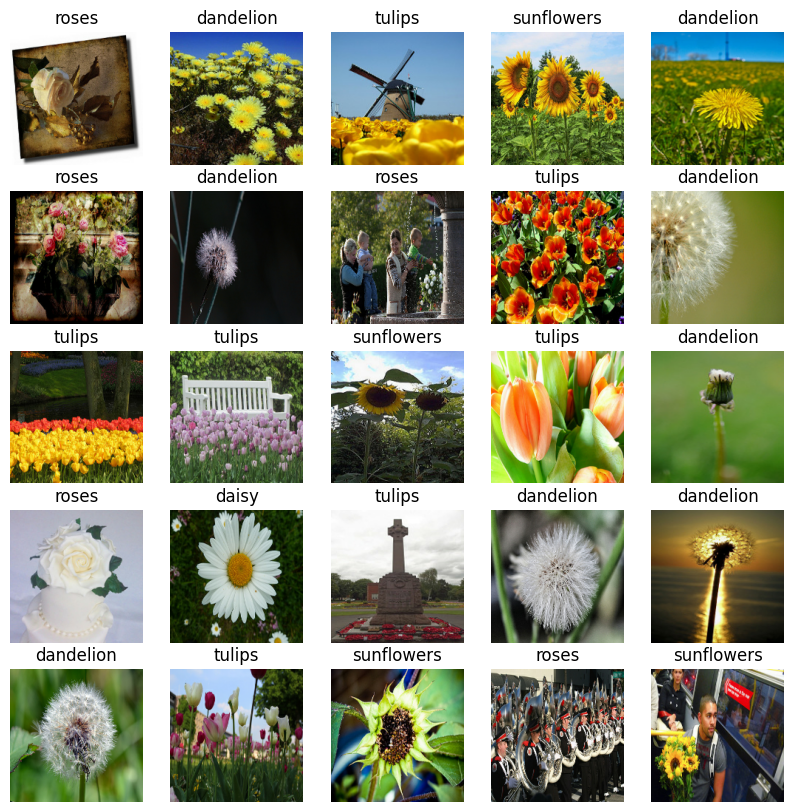

In [7]:
plt.figure(figsize=(10,10))
for imgs, lbls in trainingDataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(classNames[lbls[i]])
        plt.axis('off')

## Manual iteration over the dataset

In [8]:
for imgBatch, lblBatch in trainingDataset:
    print(f'image batch (shapes, height, width, rgb) = {imgBatch.shape}')
    print(f'label batch (number of images being used) = {lblBatch.shape}')
    break

image batch (shapes, height, width, rgb) = (32, 180, 180, 3)
label batch (number of images being used) = (32,)


the image batch can be broken up into 32 image shapes of 180x180 using RGB (the 3 is a reference to RGB).  
the label batch of '32' is a reference to the 32 images being used.

## Configure the dataset for performance

In [9]:
autotune = tf.data.AUTOTUNE

trainingDataset = trainingDataset.cache().shuffle(1000).prefetch(buffer_size=autotune)
validationDataset = validationDataset.cache().prefetch(buffer_size=autotune)

## Standardize the data

In [10]:
normalLayer = layers.Rescaling(1./255)

In [11]:
normalDataset = trainingDataset.map(lambda x, y: (normalLayer(x), y))
imgBatch, lblBatch = next(iter(normalDataset))
firstImg = imgBatch[0]
print(np.min(firstImg), np.max(firstImg))

0.0 0.9997822


## A basic Keras model

In [12]:
numClasses = len(classNames)

mdl = Sequential([
    layers.Rescaling(1./255, input_shape = (imgHeight, imgWidth, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClasses)
])

## Compile the model

In [13]:
mdl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
mdl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 16)        2

## Training the model

In [15]:
epochs = 10

history = mdl.fit(
    trainingDataset,
    validation_data= validationDataset,
    epochs= epochs
)

Epoch 1/10


92/92 [==============================] - 19s 200ms/step - loss: 1.2478 - accuracy: 0.4653 - val_loss: 1.0834 - val_accuracy: 0.5354
Epoch 2/10
92/92 [==============================] - 18s 197ms/step - loss: 1.0080 - accuracy: 0.5978 - val_loss: 1.0941 - val_accuracy: 0.5640
Epoch 3/10
92/92 [==============================] - 18s 195ms/step - loss: 0.8748 - accuracy: 0.6645 - val_loss: 0.9053 - val_accuracy: 0.6390
Epoch 4/10
92/92 [==============================] - 18s 195ms/step - loss: 0.7530 - accuracy: 0.7187 - val_loss: 0.9263 - val_accuracy: 0.6403
Epoch 5/10
92/92 [==============================] - 18s 194ms/step - loss: 0.6094 - accuracy: 0.7718 - val_loss: 1.0082 - val_accuracy: 0.6294
Epoch 6/10
92/92 [==============================] - 18s 201ms/step - loss: 0.4407 - accuracy: 0.8454 - val_loss: 0.9585 - val_accuracy: 0.6240
Epoch 7/10
92/92 [==============================] - 18s 196ms/step - loss: 0.3118 - accuracy: 0.8978 - val_loss: 1.0392 - val_accuracy: 0.6553
Epoch 8/10

## Visualize training and validation results

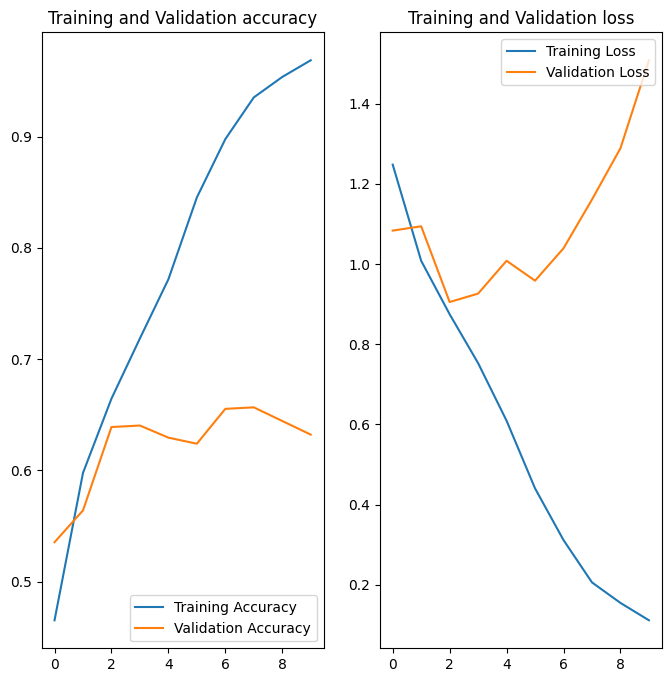

In [16]:
accuracy = history.history['accuracy']
valAccuracy = history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']

epochsRange = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(epochsRange, accuracy, label='Training Accuracy')
plt.plot(epochsRange, valAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(epochsRange, loss, label='Training Loss')
plt.plot(epochsRange, valLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

## Data augmentation

In [17]:
dataAug = keras.Sequential(
    [
        layers.RandomFlip('horizontal', input_shape=(imgHeight, imgWidth, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ]
)

### Visualize the data augmentation

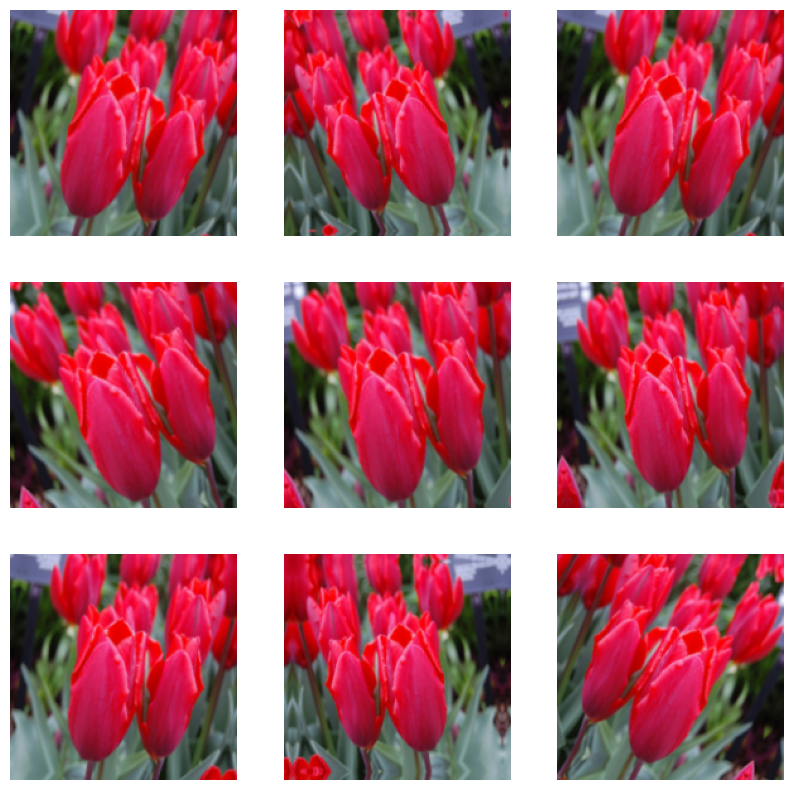

In [18]:
plt.figure(figsize=(10, 10))

for imgs, _ in trainingDataset.take(1):
    for i in range(9):
        augImgs = dataAug(imgs)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augImgs[0].numpy().astype('uint8'))
        plt.axis('off')

## Dropout training

In [19]:
mdl = Sequential([
    dataAug,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClasses, name="outputs")
])

## Compile and retrain the model

In [20]:
mdl.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [21]:
mdl.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [22]:
epochs = 10

history = mdl.fit(
    trainingDataset,
    validation_data=validationDataset,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 29s 308ms/step - loss: 1.3748 - accuracy: 0.4295 - val_loss: 1.1482 - val_accuracy: 0.5409
Epoch 2/10
92/92 [==============================] - 28s 308ms/step - loss: 1.0651 - accuracy: 0.5763 - val_loss: 1.1026 - val_accuracy: 0.5763
Epoch 3/10
92/92 [==============================] - 28s 304ms/step - loss: 0.9687 - accuracy: 0.6165 - val_loss: 0.9414 - val_accuracy: 0.6185
Epoch 4/10
92/92 [==============================] - 29s 310ms/step - loss: 0.8675 - accuracy: 0.6689 - val_loss: 0.8637 - val_accuracy: 0.6757
Epoch 5/10
92/92 [==============================] - 28s 307ms/step - loss: 0.8243 - accuracy: 0.6829 - val_loss: 0.8625 - val_accuracy: 0.6689
Epoch 6/10
92/92 [==============================] - 29s 311ms/step - loss: 0.7738 - accuracy: 0.6993 - val_loss: 0.7816 - val_accuracy: 0.6866
Epoch 7/10
92/92 [==============================] - 29s 310ms/step - loss: 0.7135 - accuracy: 0.7381 - val_loss: 0.8421 - val_accuracy: 0.6785

## Visualizing the new training results

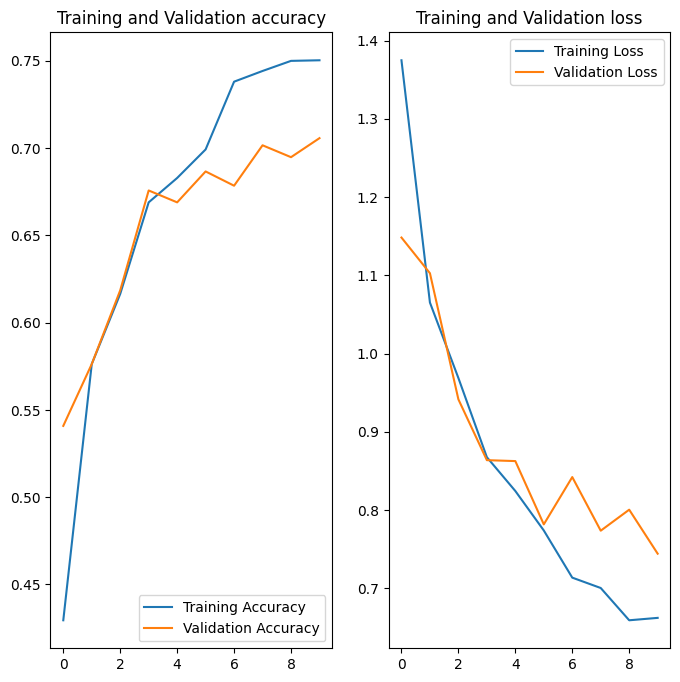

In [23]:
accuracy = history.history['accuracy']
valAccuracy = history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']

epochsRange = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(epochsRange, accuracy, label='Training Accuracy')
plt.plot(epochsRange, valAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(epochsRange, loss, label='Training Loss')
plt.plot(epochsRange, valLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

## Predicting an image of a sunflower using the keras model

In [24]:
sunflowerUrl = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
sunflowerPath = tf.keras.utils.get_file('Red_sunflower', origin=sunflowerUrl)

img = tf.keras.utils.load_img(
    sunflowerPath, target_size = (imgHeight, imgWidth)
)

imgArray = tf.keras.utils.img_to_array(img)
imgArray = tf.expand_dims(imgArray, 0)

pred = mdl.predict(imgArray)
score = tf.nn.softmax(pred[0])

print(f'Predicting that this image is from the class {classNames[np.argmax(score)]} with a {100 * np.max(score)}% confidence ')

1/1 [==============================] - 0s 87ms/step
Predicting that this image is from the class sunflowers with a 98.58394265174866% confidence 


## Converting Keras model to Tensorflow Lite Model

In [25]:
conv = tf.lite.TFLiteConverter.from_keras_model(mdl)
tfMdl = conv.convert()

with open('model.tflite', 'wb') as f:
    f.write(tfMdl)

INFO:tensorflow:Assets written to: C:\Users\trai4\AppData\Local\Temp\tmpcfed9ktd\assets


INFO:tensorflow:Assets written to: C:\Users\trai4\AppData\Local\Temp\tmpcfed9ktd\assets


## Running the newly converted Tensorflow lite model

In [26]:
TFMDLPATH = 'model.tflite'

interpreter = tf.lite.Interpreter(model_path=TFMDLPATH)

In [27]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [28]:
classifyLite = interpreter.get_signature_runner('serving_default')


In [30]:
predLite = classifyLite(sequential_1_input=imgArray)['outputs']
scoreLite = tf.nn.softmax(predLite)

### Checking the prediction results for the tensorflow lite model

In [31]:
print(f'Predicting that this image is from the class {classNames[np.argmax(scoreLite)]} with a {100 * np.max(scoreLite)}% confidence ')

Predicting that this image is from the class sunflowers with a 98.58394265174866% confidence 


### Checking to see how similar the keras model prediction is to the tensorflow lite models prediction

In [32]:
print(np.max(np.abs(pred - predLite)))

3.33786e-06


## Conclusion
This example demonstrates the usage of two machine learning models: Keras and TensorFlow Lite. Although further training is needed to improve accuracy, the initial results provide a foundation for understanding their capabilities. Keras, as a higher-level deep learning framework, offers a user-friendly interface for training and experimentation. TensorFlow Lite, designed for limited devices, enables efficient on-device deployment. Both models have their strengths and can be utilized effectively based on specific requirements. Overall, this example provides valuable insights into the potential of these models in flower classification and other machine learning tasks.
